In [1]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
data = os.popen('../build/tann test greedy-net ../datasets/siftsmall-128-euclidean.hdf5').read()
print(data)
data = np.array(json.loads(data))
print(data)

Try to read /test [I16]... --> size: 100x128
Try to read /train [I16]... --> size: 10000x128
[Linear Search]
Build time: 44 ns
Query time: 53109298 ns
[Greedy Net, shard_count=1]
Build time: 4960781814 ns
Set pool_size=0
Query time: 830782 ns
QPS=120369
recall=20
Set pool_size=1
Query time: 682196 ns
QPS=146585
recall=20
Set pool_size=2
Query time: 1137605 ns
QPS=87904
recall=40
Set pool_size=3
Query time: 1692653 ns
QPS=59078.9
recall=46
Set pool_size=4
Query time: 2218845 ns
QPS=45068.5
recall=48
Set pool_size=5
Query time: 2718778 ns
QPS=36781.2
recall=54
Set pool_size=6
Query time: 3375397 ns
QPS=29626.1
recall=58
Set pool_size=7
Query time: 3900468 ns
QPS=25637.9
recall=60
Set pool_size=8
Query time: 4380962 ns
QPS=22826
recall=62
Set pool_size=9
Query time: 4825269 ns
QPS=20724.2
recall=63
Set pool_size=10
Query time: 5395059 ns
QPS=18535.5
recall=63
Set pool_size=11
Query time: 5771105 ns
QPS=17327.7
recall=67
Set pool_size=12
Query time: 6501888 ns
QPS=15380.1
recall=67
Set poo

[[1,0,120368.5203,20.0000],[1,1,146585.4388,20.0000],[1,2,87903.9737,40.0000],[1,3,59078.8543,46.0000],[1,4,45068.4928,48.0000],[1,5,36781.2304,54.0000],[1,6,29626.1447,58.0000],[1,7,25637.9491,60.0000],[1,8,22826.0368,62.0000],[1,9,20724.2332,63.0000],[1,10,18535.4785,63.0000],[1,11,17327.7041,67.0000],[1,12,15380.1480,67.0000],[1,13,13935.1070,67.0000],[1,14,13389.5337,67.0000],[1,15,12064.1873,68.0000],[1,16,12002.3669,69.0000],[1,17,10441.3049,71.0000],[1,18,10795.5884,73.0000],[1,19,9815.6137,76.0000],[1,20,9704.3389,78.0000],[1,21,9278.8428,79.0000],[1,22,8883.1950,79.0000],[1,23,8839.1781,80.0000],[1,24,8540.7774,82.0000],[1,25,8226.8227,82.0000],[1,26,7927.1847,83.0000],[1,27,7628.6158,84.0000],[1,28,6849.8997,84.0000],[1,29,6744.8730,84.0000],[2,0,62019.4654,46.0000],[2,1,84442.7706,46.0000],[2,2,45226.1329,62.0000],[2,3,29444.7168,70.0000],[2,4,24374.0738,74.0000],[2,5,18759.7234,76.0000],[2,6,15646.0611,79.0000],[2,7,13350.7819,82.0000],[2,8,11554.5971,82.0000],[2,9,10588.67

Query time: 138630512 ns
QPS=721.342
recall=100
Set pool_size=29
Query time: 142331315 ns
QPS=702.586
recall=100



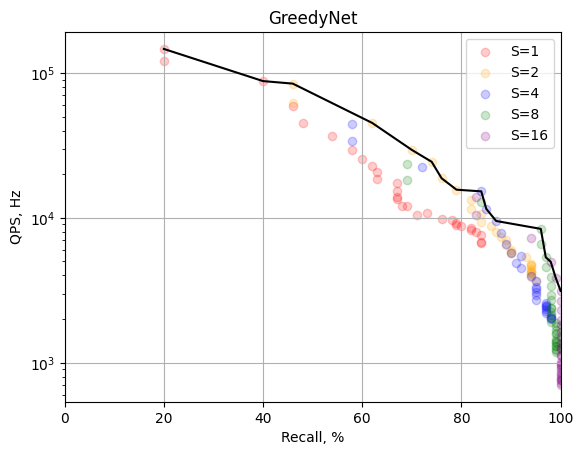

In [32]:
n = data.shape[0]
SC = data[:,0]
QPS = data[:,2]
RECALL = data[:,3]
plt.scatter(RECALL[SC==1], QPS[SC==1], c='red', alpha=0.2, label="S=1")
plt.scatter(RECALL[SC==2], QPS[SC==2], c='orange', alpha=0.2, label="S=2")
plt.scatter(RECALL[SC==4], QPS[SC==4], c='blue', alpha=0.2, label="S=4")
plt.scatter(RECALL[SC==8], QPS[SC==8], c='green', alpha=0.2, label="S=8")
plt.scatter(RECALL[SC==16], QPS[SC==16], c='purple', alpha=0.2, label="S=16")
plt.xlim(0, 100)
plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black')
plt.xlabel('Recall, %')
plt.ylabel('QPS, Hz')
plt.title('GreedyNet')
plt.grid()
plt.legend()

plt.show()

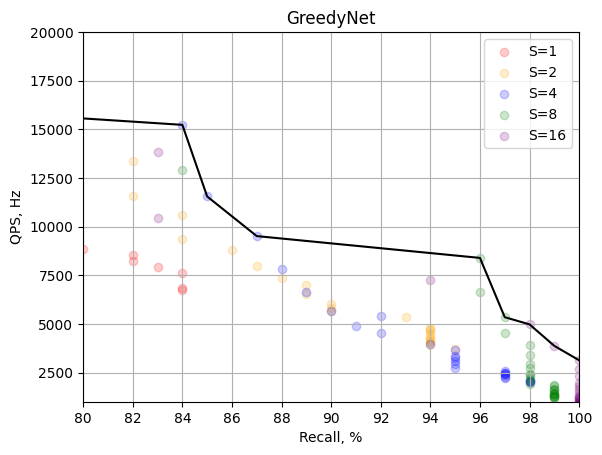

In [60]:
n = data.shape[0]
SC = data[data[:,1] < 2000,0]
QPS = data[data[:,1] < 2000,2]
RECALL = data[data[:,1] < 2000,3]
n = SC.shape[0]
plt.scatter(RECALL[SC==1], QPS[SC==1], c='red', alpha=0.2, label="S=1")
plt.scatter(RECALL[SC==2], QPS[SC==2], c='orange', alpha=0.2, label="S=2")
plt.scatter(RECALL[SC==4], QPS[SC==4], c='blue', alpha=0.2, label="S=4")
plt.scatter(RECALL[SC==8], QPS[SC==8], c='green', alpha=0.2, label="S=8")
plt.scatter(RECALL[SC==16], QPS[SC==16], c='purple', alpha=0.2, label="S=16")
plt.xlim(80, 100)
plt.ylim(10**3, 20000)
# plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black')
plt.xlabel('Recall, %')
plt.ylabel('QPS, Hz')
plt.title('GreedyNet')

plt.xticks(np.linspace(80, 100, 11))

plt.grid()
plt.legend()

plt.show()